In [49]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler
from itertools import combinations

mnist = tf.keras.datasets.mnist

We load the dataset, normalise it to [-1, 1] and flatten it

In [50]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

# normalise to [-1, 1] so that PCA is not swayed by features with bigger value ranges.
x_train, x_test = x_train/127.5 - 1, x_test/127.5 - 1

# each pixel is a feature. num of pixels = height x width
nb_features = np.prod(x_train.shape[1:])

x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### Task 1. Data visualisation (10 points)

In [51]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)

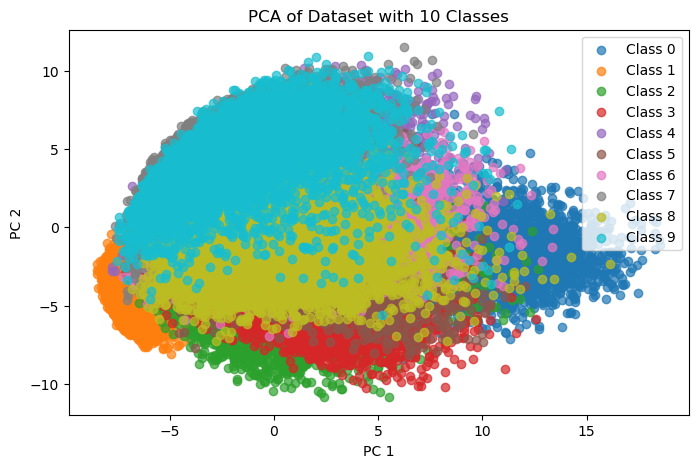

In [52]:
plt.figure(figsize=(8, 5))
# Plot all classes iteratively, on same plot
for digit in range(10):
    plt.scatter(x_train_pca[y_train == digit, 0], x_train_pca[y_train == digit, 1], label=f'Class {digit}', alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 

plt.legend(by_label.values(), by_label.keys())
plt.title('PCA of Dataset with 10 Classes')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()


We get a general idea of the whole dataset but we have to to brake it into smaller part in order to understand it better

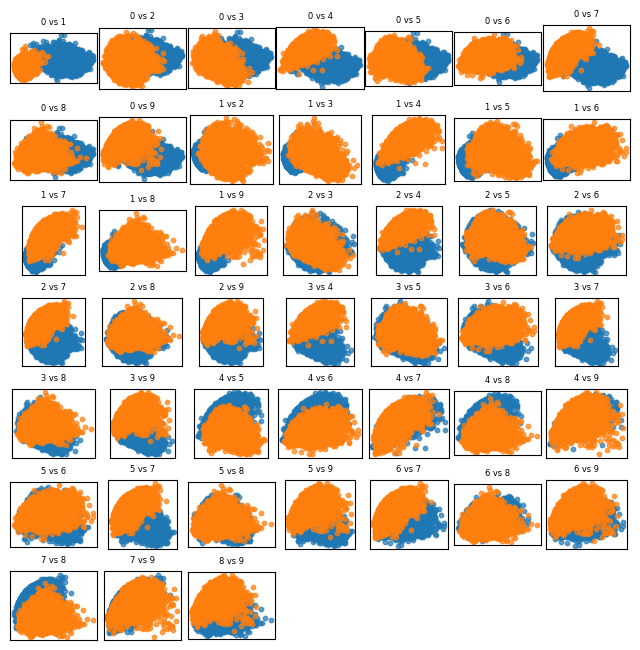

Average silhouette score is: 0.337


In [53]:
# all pairs of classes
class_pairs = list(combinations(range(10), 2))

# set up plot table shape
fig, axes = plt.subplots(len(class_pairs) // 7 + (len(class_pairs) % 7 != 0), 7, figsize=(8, 8))

axes = axes.flatten()

total_sil_score = 0

# for all pairs of digits, take their pca data that we calculated before, plot them and get their silhouette score
for idx, (class1, class2) in enumerate(class_pairs):
    ax = axes[idx]

    cond = (y_train == class1) + (y_train == class2)
    x_train_pca_bin = x_train_pca[cond, :]
    y_train_pca_bin = y_train [cond] * 1

    y_train_pca_bin = np.where(y_train_pca_bin == class1, -1, 1)

    # this calculates the similarity of the cluster's samples which gives a hint to their separability. 
    # Values range from [0 to 1] for datasets with no misclassifications. Higher is better
    sil_score = silhouette_score(x_train_pca_bin, y_train_pca_bin)
    total_sil_score += sil_score
    
    # plot first and second component, for one class and then the other
    ax.scatter(x_train_pca_bin[y_train_pca_bin == -1, 0], x_train_pca_bin[y_train_pca_bin == -1, 1], alpha=0.7, s=10, label=f'Class {class1}')
    ax.scatter(x_train_pca_bin[y_train_pca_bin == 1, 0], x_train_pca_bin[y_train_pca_bin == 1, 1], alpha=0.7, s=10, label=f'Class {class2}')
    
    # Making plot less cluttered
    ax.set_title(f'{class1} vs {class2}', fontsize=6)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove empty subplots
for idx in range(len(class_pairs), len(axes)):
    fig.delaxes(axes[idx])

# Reuce white space
plt.subplots_adjust(wspace= 0.02, hspace=0.33)
plt.show()

print('Average silhouette score is:', round(total_sil_score/len(class_pairs), 3))

No pair of classes seems easily seperable. We will perform PCA in pairs in order to reduce the noise and influence of other classes.

In [54]:
# function that accepts two digits and returns the corresponding slices of train data and labels
def digit_pairs(digit1, digit2):
    if digit1 == digit2:
        print('Same digit given twice')
        raise ValueError
    
    cond = (y_train==digit1) + (y_train==digit2)
    x_train_binary = x_train[cond, :]
    y_train_binary = y_train[cond].astype(int)
    y_train_binary = np.where(y_train_binary == digit1, -1, 1)

    return x_train_binary, y_train_binary

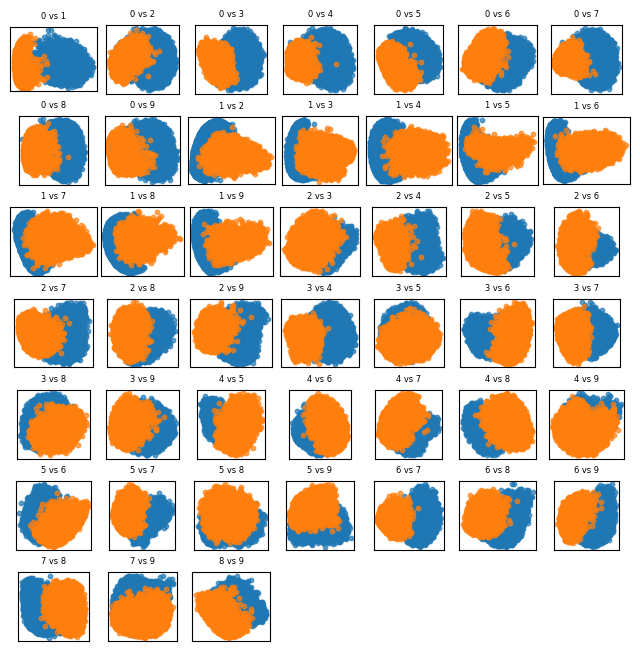

Average silhouette score is: 0.407


In [55]:
# Same as before, but now PCA is done on each slice of digit pairs, individually
class_pairs = list(combinations(range(10), 2))

fig, axes = plt.subplots(len(class_pairs) // 7 + (len(class_pairs) % 7 != 0), 7, figsize=(8, 8))

axes = axes.flatten()

total_sil_score = 0

for idx, (class1, class2) in enumerate(class_pairs):
    ax = axes[idx]

    x_train_bin, y_train_bin = digit_pairs(class1, class2)
    pca = PCA(n_components=2)
    x_train_bin_pca = pca.fit_transform(x_train_bin)

    sil_score = silhouette_score(x_train_bin_pca, y_train_bin)
    total_sil_score += sil_score
    
    # Plot
    ax.scatter(x_train_bin_pca[y_train_bin == -1, 0], x_train_bin_pca[y_train_bin == -1, 1], alpha=0.7, s=10, label=f'Class {class1}')
    ax.scatter(x_train_bin_pca[y_train_bin == 1, 0], x_train_bin_pca[y_train_bin == 1, 1], alpha=0.7, s=10, label=f'Class {class2}')
    
    # Making plot less cluttered
    ax.set_title(f'{class1} vs {class2}', fontsize=6)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

# Remove empty subplots
for idx in range(len(class_pairs), len(axes)):
    fig.delaxes(axes[idx])

# Reuce white space
plt.subplots_adjust(wspace= 0.02, hspace=0.33)
plt.show()

print('Average silhouette score is:', round(total_sil_score/len(class_pairs), 3))

We see that the silhouette score has increased, indicating that the samples of each class are better formed than before. Indeed, a visual inspection reveals that most pairs now seem more easily seperable. No pair appears perfectly linearily seperable but a lot (3,4), (3,7), (6, 9) appear more distinct. This concludes Part 1. Next, we will try to train a perceptron to be able to seperate two classes.

### Task 2. Perceptrons (10 points)

In [ ]:
def predict(x, w, b):
    weighted_sum = np.dot(x, w)
    result = 1 if weighted_sum > b else -1
    return result

def optimize(x, y):
    iteration = 0
    error = np.inf
    m, n = x.shape
    w = np.random.uniform(-1, 1, n)
    b = np.random.uniform(-1, 1)
    learning_rate = 0.002
    while (iteration <= 1000) & (error > 1e-3):
        error = 0
        fp, fn = 0, 0
        predictions  = []
        for sample, target in zip(x, y):
            prediction = predict(sample, w, b)
            predictions.append(prediction)
            if prediction != target:
                if prediction > target:
                    fp += 1
                else:
                    fn += 1
                error = error + 1
                w = w + learning_rate*(target-prediction)*sample
                b = b + learning_rate*(target-prediction)

        iteration += 1        
        print("Iteration:", iteration, 'with error:', error, fp, fn)
    return predictions

binary_x_train, binary_y_train = digit_pairs(1, 7)
preds = optimize(binary_x_train, binary_y_train)

In [ ]:
for i in zip(preds, binary_y_train):
    if i[0] != i[1]:
        print(i)
print(len(preds))

In [86]:
digit = binary_x_train[8].reshape(28, 28)

In [ ]:
binary_y_train[:6]

In [88]:
import numpy as np
import matplotlib.pyplot as plt

def print_digit(sample_no):
    digit = sample_no.reshape(28, 28)

    plt.imshow(digit, cmap='gray')  # Use 'gray' colormap for grayscale images
    plt.axis('off')  # Hide the axes
    plt.show()

In [89]:
sorted_labels = np.argsort(y_train)
x_train_sorted = x_train[sorted_labels]

In [ ]:
print_digit(x_train_sorted[59999])

## 3

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


import datetime

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255
y_train = np.eye(10)[y_train]
X_test = X_test/ 255
y_test = np.eye(10)[y_test]

n_train = X_train.shape[0]
n_test = X_test.shape[0]

X_train.resize((n_train, nb_features))
X_test.resize((n_test, nb_features))

model = Sequential()

model.add(Dense(1000, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,          # Log weight histograms every epoch
    write_graph=True,          # Log the computation graph
    write_images=True,         # Log model weights as images
    update_freq='epoch'        # How often to write logs (defaults to every batch)
)

history = model.fit(X_train, y_train, 
                    epochs=5,               # Number of epochs
                    batch_size=128,           # Batch size
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])     # Split some of the data for validation

test_loss, test_acc = model.evaluate(X_test, y_test)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model2 = Sequential()

model2.add(Dense(1000, input_shape=(X_test.shape[1],), activation='relu'))
model2.add(Dense(3000, activation='relu'))
model2.add(Dense(1000, activation='relu'))
model2.add(Dense(500, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,          # Log weight histograms every epoch
    write_graph=True,          # Log the computation graph
    write_images=True,         # Log model weights as images
    update_freq='epoch'        # How often to write logs (defaults to every batch)
)

history = model2.fit(X_train, y_train, 
                    epochs=5,               # Number of epochs
                    batch_size=128,           # Batch size
                    validation_split=0.2,
                    callbacks=[tensorboard_callback])     # Split some of the data for validation

test_loss, test_acc = model2.evaluate(X_test, y_test)